# Visualize

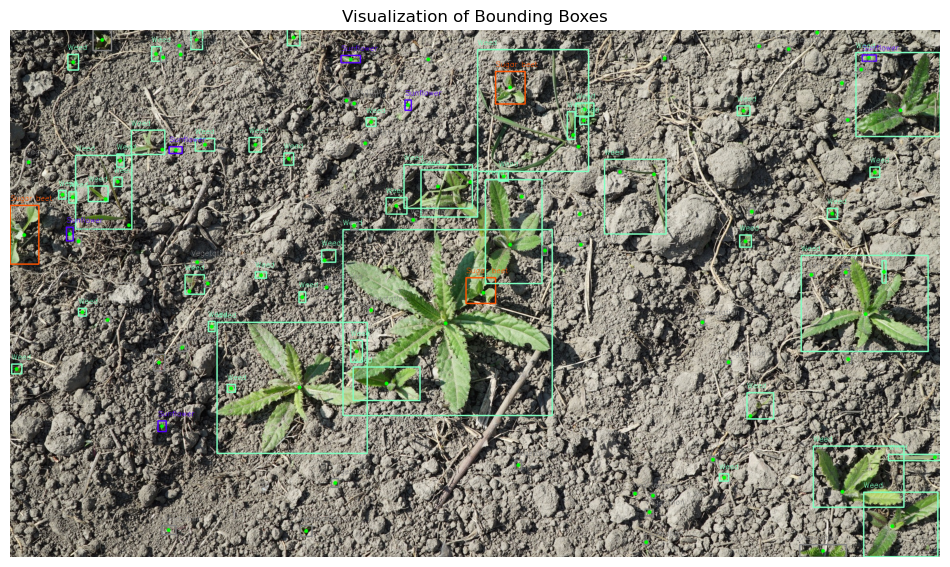

In [ ]:
import csv
import cv2
import matplotlib.pyplot as plt

# Path to your image file
image_path = 'C:\\Users\\yurim\\Documents\\University\\UM\\Year_3\\Bachelor_Thesis\\Weed_Detection_eSys\\datasets\\data\\images\\ave-0007-0000.jpg'

bbox_file_path = 'C:\\Users\\yurim\\Documents\\University\\UM\\Year_3\\Bachelor_Thesis\\Weed_Detection_eSys\\datasets\\data\\bboxes\\CropsOrWeed9Eval\\ave-0007-0000.csv'

# Label mapping dictionary
labels = {
    0: ('Maize', (255, 0, 0), [1, 2, 3, 4, 5, 6]),
    1: ('Sugar beet', (255, 85, 0), [7, 8, 9, 10, 11, 12]),
    2: ('Soy', (42, 255, 0), [94]),
    3: ('Sunflower', (85, 0, 255), [24]),
    4: ('Potato', (0, 255, 85), [18]),
    5: ('Pea', (255, 170, 0), [13]),
    6: ('Bean', (255, 0, 170), [26, 27]),
    7: ('Pumpkin', (170, 255, 0), [15]),
    8: ('Weed', (128, 255, 192),
        [31, 48, 62, 65, 68, 69, 74, 75, 81, 84, 86, 32, 29, 33, 37, 49, 30, 44, 66, 87, 89, 91, 61, 79, 34, 41, 52, 35,
         36, 78, 38, 39, 71, 72, 88, 42, 45, 70, 47, 51, 54, 58, 60, 80, 83, 96, 22, 63, 85, 56, 57, 64, 77, 50, 59, 67,
         76]),
    255: ('Vegetation', (128, 128, 128), [0])
}
# Load the image using OpenCV
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

# Convert image from BGR (OpenCV default) to RGB for Matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Copy the image for drawing
img_draw = img_rgb.copy()

# Read the bounding boxes from the CSV file
with open(bbox_file_path, 'r') as bbox_file:
    csv_reader = csv.reader(bbox_file)
    for row in csv_reader:
        # Parse the bounding box values
        left, top, right, bottom, label_id, stem_x, stem_y = map(int, row)

        # Retrieve the crop name and color using the label ID
        crop_name, color, sublabels = labels[label_id]

        # Draw the bounding box
        cv2.rectangle(img_draw, (left, top), (right, bottom), color, thickness=2)

        # Draw a small circle for the stem point
        cv2.circle(img_draw, (stem_x, stem_y), radius=4, color=(0, 255, 0), thickness=-1)

        # Put the crop label text above the bounding box
        cv2.putText(img_draw, crop_name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness=1)

# Visualize the image with Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(img_draw)
plt.title('Visualization of Bounding Boxes')
plt.axis('off')
plt.show()

# Dataset conversion and restructuring

In [ ]:
import os
import shutil
import random
from PIL import Image

# Directories
source_images_dir = "datasets\data\images"
source_annots_dir = "datasets\data\\bboxes\CropOrWeed2"
dataset_name = os.path.basename(source_annots_dir)
dest_dir = f"datasets\\yolo_{dataset_name}"

# Parameters
train_ratio = 0.8  # 80% for training, 20% for validation

# Destination directories for train/val splits
dest_images_train = os.path.join(dest_dir, "images", "train")
dest_images_val   = os.path.join(dest_dir, "images", "val")
dest_labels_train = os.path.join(dest_dir, "labels", "train")
dest_labels_val   = os.path.join(dest_dir, "labels", "val")

# Create destination directories if they don't exist
os.makedirs(dest_images_train, exist_ok=True)
os.makedirs(dest_images_val, exist_ok=True)
os.makedirs(dest_labels_train, exist_ok=True)
os.makedirs(dest_labels_val, exist_ok=True)

def convert_bbox_to_yolo(left, top, right, bottom, img_width, img_height):
    """
    Convert bounding box coordinates to YOLO format:
    <class_index> <x_center> <y_center> <width> <height>
    Coordinates are normalized by the image dimensions.
    """
    x_center = (left + right) / 2.0 / img_width
    y_center = (top + bottom) / 2.0 / img_height
    width    = (right - left) / img_width
    height   = (bottom - top) / img_height
    return x_center, y_center, width, height

# Collect list of image files that have corresponding annotation files.
valid_images = []
for img_file in os.listdir(source_images_dir):
    if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
        base_name = os.path.splitext(img_file)[0]
        annot_file = os.path.join(source_annots_dir, base_name + ".csv")
        if os.path.exists(annot_file):
            valid_images.append(img_file)

# Shuffle and split into training and validation sets
random.seed(420)  # For reproducibility
random.shuffle(valid_images)
split_index = int(len(valid_images) * train_ratio)
train_images = valid_images[:split_index]
val_images = valid_images[split_index:]

def process_images(image_list, dest_images_folder, dest_labels_folder):
    for img_file in image_list:
        base_name = os.path.splitext(img_file)[0]
        img_path = os.path.join(source_images_dir, img_file)
        annot_file = os.path.join(source_annots_dir, base_name + ".csv")
        
        # Open image to get its dimensions
        with Image.open(img_path) as img:
            img_width, img_height = img.size
        
        # Copy image to the destination folder
        shutil.copy(img_path, os.path.join(dest_images_folder, img_file))
        
        # Process the annotation file and convert to YOLO format
        dest_label_file = os.path.join(dest_labels_folder, base_name + ".txt")
        with open(annot_file, "r") as f_in, open(dest_label_file, "w") as f_out:
            for line in f_in:
                line = line.strip()
                if not line:
                    continue
                # Expected format: Left,Top,Right,Bottom,LabelID,StemX,StemY
                parts = line.split(',')
                if len(parts) < 7:
                    continue  # Skip malformed lines
                left, top, right, bottom, label_id, stem_x, stem_y = map(int, parts)
                
                # Convert the bounding box to YOLO format
                x_center, y_center, width, height = convert_bbox_to_yolo(
                    left, top, right, bottom, img_width, img_height
                )
                
                # Write the annotation: <class_index> <x_center> <y_center> <width> <height>
                f_out.write(f"{label_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Process training and validation images
process_images(train_images, dest_images_train, dest_labels_train)
process_images(val_images, dest_images_val, dest_labels_val)

print("Dataset conversion to YOLO format is complete!")

Dataset conversion to YOLO format is complete!


In [1]:
import os
import shutil
import random
from PIL import Image

# Directories
source_images_dir = "datasets\\data\\images"
source_annots_dir = "datasets\\data\\bboxes\\CropOrWeed2"
dest_dir = "datasets\\yolo_300_images"

# Destination directories
dest_images = os.path.join(dest_dir, "images")
dest_labels = os.path.join(dest_dir, "labels")

# Create destination directories if they don't exist
os.makedirs(dest_images, exist_ok=True)
os.makedirs(dest_labels, exist_ok=True)

def convert_bbox_to_yolo(left, top, right, bottom, img_width, img_height):
    """
    Convert bounding box coordinates to YOLO format:
    <class_index> <x_center> <y_center> <width> <height>
    Coordinates are normalized by the image dimensions.
    """
    x_center = (left + right) / 2.0 / img_width
    y_center = (top + bottom) / 2.0 / img_height
    width = (right - left) / img_width
    height = (bottom - top) / img_height
    return x_center, y_center, width, height

# Collect list of image files that have corresponding annotation files
valid_images = []
for img_file in os.listdir(source_images_dir):
    if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
        base_name = os.path.splitext(img_file)[0]
        annot_file = os.path.join(source_annots_dir, base_name + ".csv")
        if os.path.exists(annot_file):
            valid_images.append(img_file)

def process_images(image_list, dest_images_folder, dest_labels_folder):
    for img_file in image_list:
        base_name = os.path.splitext(img_file)[0]
        img_path = os.path.join(source_images_dir, img_file)
        annot_file = os.path.join(source_annots_dir, base_name + ".csv")
        
        # Open image to get its dimensions
        with Image.open(img_path) as img:
            img_width, img_height = img.size
        
        # Copy image to the destination folder
        shutil.copy(img_path, os.path.join(dest_images_folder, img_file))
        
        # Process the annotation file and convert to YOLO format
        dest_label_file = os.path.join(dest_labels_folder, base_name + ".txt")
        with open(annot_file, "r") as f_in, open(dest_label_file, "w") as f_out:
            for line in f_in:
                line = line.strip()
                if not line:
                    continue
                # Expected format: Left,Top,Right,Bottom,LabelID,StemX,StemY
                parts = line.split(',')
                if len(parts) < 7:
                    continue  # Skip malformed lines
                left, top, right, bottom, label_id, stem_x, stem_y = map(int, parts)
                
                # Convert the bounding box to YOLO format
                x_center, y_center, width, height = convert_bbox_to_yolo(
                    left, top, right, bottom, img_width, img_height
                )
                
                # Write the annotation: <class_index> <x_center> <y_center> <width> <height>
                f_out.write(f"{label_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                
# Randomly sample 300 images
random.seed(42)  # For reproducibility
sampled_images = random.sample(valid_images, min(300, len(valid_images)))

# Process the sampled images
process_images(sampled_images, dest_images, dest_labels)

print("Dataset with 300 images for calibration is ready!")

Dataset with 300 images for calibration is ready!


# dataset Analysis (CropOrWeed2)

In [15]:
import os

source_images_dir = "datasets\data\images"
source_annots_dir = "datasets\data\\bboxes\CropOrWeed2"
source_params_dir = "datasets\data\\params"

img_count = 0
for img_file in os.listdir(source_images_dir):
    img_count += 1
print(f"Total number of images: {img_count}")

count_m_dry = 0
count_m_med = 0
count_m_wet = 0
count_s_fine = 0
count_s_med = 0
count_s_coarse = 0
count_sunny = 0
count_diffuse = 0
count_sep_easy = 0
count_sep_medium = 0
count_sep_hard = 0
param_count = 0

app_set = 0
for param_file in os.listdir(source_params_dir):
    param_count += 1
    samples_set = param_file[:3]
    if samples_set =='ave':
        app_set += 1
    with open(os.path.join(source_params_dir, param_file), 'r') as f:
        lines = f.readlines()
        line = lines[1]
        parts = line.strip().split(',')
        # counting moisture
        switch = parts[0]
        if switch == '0':
            count_m_dry += 1
        elif switch == '1':
            count_m_med += 1
        else:
            count_m_wet += 1
        # counting soil
        switch = parts[1]
        if switch == '0':
            count_s_fine += 1
        elif switch == '1':
            count_s_med += 1
        else:
            count_s_coarse += 1
        # counting light
        switch = parts[2]
        if switch == '0':
            count_sunny += 1
        else:
            count_diffuse += 1
        # counting separation
        switch = parts[3]
        if switch == '0':
            count_sep_easy += 1
        elif switch == '1':
            count_sep_medium += 1
        else:
            count_sep_hard += 1

print(f"Total number of parameter files: {param_count}")
print(f"application set: {app_set}, experimental set: {param_count - app_set}")
print(f"Moisture: {count_m_dry} dry, {count_m_med} medium, {count_m_wet} wet")
print(f"Soil: {count_s_fine} fine, {count_s_med} medium, {count_s_coarse} coarse")
print(f"Light: {count_sunny} sunny, {count_diffuse} diffuse")
print(f"Separation: {count_sep_easy} easy, {count_sep_medium} medium, {count_sep_hard} hard")

# counting crops and weeds
print(f"\ndataset: {os.path.basename(source_annots_dir)}")
annot_count = 0
weeds_count = 0
crops_count = 0
for annot_file in os.listdir(source_annots_dir):
    annot_count += 1
    with open(os.path.join(source_annots_dir, annot_file), 'r') as f:
        lines = f.readlines()
        # 0 crop 1 weed
        for line in lines:
            parts = line.strip().split(',')
            if parts[4] == '0':
                crops_count += 1
            elif parts[4] == '1':
                weeds_count += 1

print(f"Total number of annotation files: {annot_count}")
print(f"Total number of crops: {crops_count}")
print(f"Total number of weeds: {weeds_count}")
print(f"\naverage number of crops per image: {crops_count / annot_count}")
print(f"average number of weeds per image: {weeds_count / annot_count}")
print(f"average number of annotations per image: {(crops_count + weeds_count) / annot_count}")



Total number of images: 8034
Total number of parameter files: 8034
application set: 3044, experimental set: 4990
Moisture: 4171 dry, 2194 medium, 1669 wet
Soil: 7910 fine, 98 medium, 26 coarse
Light: 5819 sunny, 2215 diffuse
Separation: 7704 easy, 309 medium, 21 hard

dataset: CropOrWeed2
Total number of annotation files: 7705
Total number of crops: 20765
Total number of weeds: 57523

average number of crops per image: 2.6950032446463337
average number of weeds per image: 7.465671641791045
average number of annotations per image: 10.160674886437379
